# About Dataset

## Context
This dataset contains information on user preference data from **73,516 users** on **12,294 anime**. Each user is able to add anime to their completed list and give it a rating, and this dataset is a compilation of those ratings.

## Content

### Anime.csv
- **anime_id** - myanimelist.net's unique id identifying an anime
- **name** - full name of anime
- **genre** - comma separated list of genres for this anime
- **type** - movie, TV, OVA, etc.
- **episodes** - how many episodes in this show (1 if movie)
- **rating** - average rating out of 10 for this anime
- **members** - number of community members that are in this anime's "group"

### Rating.csv
- **user_id** - non identifiable randomly generated user id
- **anime_id** - the anime that this user has rated
- **rating** - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating)

## Acknowledgements
Thanks to myanimelist.net API for providing anime data and user ratings.

## Inspiration
Building a better anime recommendation system based only on user viewing history.


## 1. Import Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import html
from collections import Counter

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


## 2. Load Data


In [2]:
anime = pd.read_csv('anime.csv')
anime_rating = pd.read_csv('rating.csv')

print("Data loaded successfully!")
print(f"Anime dataset shape: {anime.shape}")
print(f"Rating dataset shape: {anime_rating.shape}")


Data loaded successfully!
Anime dataset shape: (12294, 7)
Rating dataset shape: (7813737, 3)


## 3. Initial Data Exploration


In [3]:
# Display first few rows
print("=== Anime Dataset ===")
display(anime.head())
print("\n=== Rating Dataset ===")
display(anime_rating.head())


=== Anime Dataset ===


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



=== Rating Dataset ===


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
# Basic statistics
print('Jumlah judul anime: ', len(anime.anime_id.unique()))
print('Jumlah genre anime: ', len(anime.genre.unique()))
print('Jumlah user: ', len(anime_rating.user_id.unique()))
print('Jumlah rating: ', len(anime_rating))


Jumlah judul anime:  12294
Jumlah genre anime:  3265
Jumlah user:  73515
Jumlah rating:  7813737


In [5]:
# Dataset info
print("=== Anime Dataset Info ===")
anime.info()
print("\n=== Rating Dataset Info ===")
anime_rating.info()


=== Anime Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

=== Rating Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## 4. Data Quality Validation


In [6]:
def validate_data(df, df_name):
    """Validasi kualitas data"""
    print(f"\n=== Validasi {df_name} ===")
    print(f"Shape: {df.shape}")
    print(f"Duplicates: {df.duplicated().sum()}")
    print(f"\nMissing values:")
    missing = df.isna().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # Validasi range rating (harus 0-10)
    if 'rating' in df.columns:
        invalid_ratings = df[(df['rating'] < 0) | (df['rating'] > 10)]
        if len(invalid_ratings) > 0:
            print(f"\nInvalid ratings (not 0-10): {len(invalid_ratings)}")
            print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")
    
    return missing_df

# Validasi kedua dataset
missing_anime = validate_data(anime, "Anime Dataset")
missing_rating = validate_data(anime_rating, "Rating Dataset")



=== Validasi Anime Dataset ===
Shape: (12294, 7)
Duplicates: 0

Missing values:
        Missing Count  Missing Percentage
genre              62            0.504311
type               25            0.203351
rating            230            1.870831

=== Validasi Rating Dataset ===
Shape: (7813737, 3)
Duplicates: 1

Missing values:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

Invalid ratings (not 0-10): 1476496
Rating range: -1 - 10


## 5. Data Preprocessing

### 5.1 Handling Missing Values


In [7]:
# Analisis missing values lebih detail
print("=== Missing Values Analysis ===")
print("\nAnime Dataset:")
print(anime.isna().sum())
print(f"\nTotal rows before: {len(anime)}")

# Strategi: Drop rows dengan missing values pada kolom penting
# Genre dan Type bisa diisi dengan "Unknown", tapi untuk konsistensi kita drop
anime = anime.dropna()
print(f"Total rows after dropna: {len(anime)}")


=== Missing Values Analysis ===

Anime Dataset:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Total rows before: 12294
Total rows after dropna: 12017


In [8]:
# Check missing values in rating dataset
print("Rating Dataset missing values:")
print(anime_rating.isna().sum())


Rating Dataset missing values:
user_id     0
anime_id    0
rating      0
dtype: int64


### 5.2 Handling Duplicates


In [9]:
# Check duplicates in anime dataset
dup_anime = anime[anime.duplicated()].shape[0]
print(f"Terdapat {dup_anime} duplikat dari {anime.shape[0]} sample pada anime dataset.")

# Check duplicates in rating dataset
dup_rating = anime_rating[anime_rating.duplicated()].shape[0]
print(f"Terdapat {dup_rating} duplikat dari {anime_rating.shape[0]} sample pada rating anime dataset.")

# Remove duplicates from rating dataset
if dup_rating > 0:
    anime_rating.drop_duplicates(keep='first', inplace=True)
    print(f"Sample rating anime dataset sekarang adalah {anime_rating.shape[0]}.")


Terdapat 0 duplikat dari 12017 sample pada anime dataset.
Terdapat 1 duplikat dari 7813737 sample pada rating anime dataset.
Sample rating anime dataset sekarang adalah 7813736.


### 5.3 Data Type Conversion


In [10]:
# Convert episodes to numeric (handle 'Unknown' or invalid values)
print("Episodes data type before:", anime['episodes'].dtype)
print("Sample episodes values:", anime['episodes'].head(10).tolist())

# Convert to numeric, invalid values become NaN
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')

# Check how many became NaN
episodes_nan = anime['episodes'].isna().sum()
print(f"\nEpisodes converted to numeric. NaN count: {episodes_nan}")

# Fill NaN episodes with median or 1 (for movies)
if episodes_nan > 0:
    median_episodes = anime['episodes'].median()
    anime['episodes'] = anime['episodes'].fillna(median_episodes)
    print(f"Filled {episodes_nan} NaN episodes with median: {median_episodes}")

print("\nEpisodes data type after:", anime['episodes'].dtype)
print("Episodes statistics:")
print(anime['episodes'].describe())


Episodes data type before: object
Sample episodes values: ['1', '64', '51', '24', '51', '10', '148', '110', '1', '13']

Episodes converted to numeric. NaN count: 187
Filled 187 NaN episodes with median: 2.0

Episodes data type after: float64
Episodes statistics:
count    12017.000000
mean        12.323542
std         46.747242
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64


### 5.4 Text Cleaning


In [11]:
def text_cleaning(text):
    """Fungsi untuk membersihkan text dari karakter tidak diinginkan"""
    if not isinstance(text, str):
        return text
    
    # Decode HTML entities
    text = html.unescape(text)
    
    # Hapus semua tanda kutip dan apostrof
    text = re.sub(r'["\']', '', text)
    text = re.sub(r'\.hack//', '', text)
    text = re.sub(r'&', 'and', text)
    
    return text

# Perbaikan: gunakan .copy() untuk menghindari SettingWithCopyWarning
anime = anime.copy()
anime['name'] = anime['name'].apply(text_cleaning)

print("Text cleaning completed!")
print("Sample cleaned names:")
print(anime['name'].head(10))


Text cleaning completed!
Sample cleaned names:
0                                       Kimi no Na wa.
1                     Fullmetal Alchemist: Brotherhood
2                                             Gintama°
3                                          Steins;Gate
4                                              Gintama
5    Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...
6                               Hunter x Hunter (2011)
7                                 Ginga Eiyuu Densetsu
8    Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
9                                   Gintama: Enchousen
Name: name, dtype: object


### 5.5 Outlier Detection


In [12]:
def detect_outliers_iqr(df, column):
    """Deteksi outlier menggunakan IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Deteksi outlier pada rating
outliers_rating, lower_r, upper_r = detect_outliers_iqr(anime, 'rating')
print(f"Outliers in rating: {len(outliers_rating)}")
print(f"Rating bounds: [{lower_r:.2f}, {upper_r:.2f}]")

# Deteksi outlier pada members
outliers_members, lower_m, upper_m = detect_outliers_iqr(anime, 'members')
print(f"\nOutliers in members: {len(outliers_members)}")
print(f"Members bounds: [{lower_m:.2f}, {upper_m:.2f}]")

# Note: Kita tidak akan menghapus outlier karena mungkin valid (anime populer memang punya members banyak)
print("\nNote: Outliers tidak dihapus karena mungkin valid data")


Outliers in rating: 235
Rating bounds: [3.95, 9.12]

Outliers in members: 1869
Members bounds: [-13819.50, 23632.50]

Note: Outliers tidak dihapus karena mungkin valid data


### 5.6 Data Filtering


In [13]:
# Filter rating -1 (user watched but didn't rate)
print(f"Rating dataset before filtering: {len(anime_rating)}")
print(f"Ratings with -1: {len(anime_rating[anime_rating.rating == -1])}")

anime_rating = anime_rating[~(anime_rating.rating == -1)]
print(f"Rating dataset after filtering: {len(anime_rating)}")

# Validasi rating range
invalid_ratings = anime_rating[(anime_rating['rating'] < 0) | (anime_rating['rating'] > 10)]
if len(invalid_ratings) > 0:
    print(f"\nWarning: Found {len(invalid_ratings)} invalid ratings (not 0-10)")
else:
    print("\nAll ratings are in valid range (0-10)")


Rating dataset before filtering: 7813736
Ratings with -1: 1476496
Rating dataset after filtering: 6337240

All ratings are in valid range (0-10)


### 5.7 Feature Engineering


In [14]:
# Jumlah genre per anime
anime['genre_list'] = anime['genre'].apply(
    lambda x: [g.strip() for g in str(x).split(',')] if pd.notna(x) else []
)
anime['genre_count'] = anime['genre_list'].apply(len)

print("Genre count statistics:")
print(anime['genre_count'].describe())


Genre count statistics:
count    12017.000000
mean         2.962054
std          1.665691
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
Name: genre_count, dtype: float64


In [15]:
# Analisis genre paling populer
all_genres = [genre for sublist in anime['genre_list'] for genre in sublist]
genre_counts = Counter(all_genres)
print("Top 15 Most Popular Genres:")
for genre, count in genre_counts.most_common(15):
    print(f"  {genre}: {count}")


Top 15 Most Popular Genres:
  Comedy: 4575
  Action: 2768
  Adventure: 2316
  Fantasy: 2242
  Sci-Fi: 2036
  Drama: 1977
  Shounen: 1684
  Kids: 1598
  Romance: 1437
  Slice of Life: 1204
  School: 1176
  Hentai: 1133
  Supernatural: 1001
  Mecha: 929
  Music: 842


In [16]:
# Normalisasi members (opsional, untuk skala yang berbeda)
scaler = MinMaxScaler()
anime['members_normalized'] = scaler.fit_transform(anime[['members']])

# Kategorisasi rating
anime['rating_category'] = pd.cut(
    anime['rating'], 
    bins=[0, 5, 7, 8, 10], 
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("Feature engineering completed!")
print("\nNew features added:")
print("- genre_list: List of genres")
print("- genre_count: Number of genres")
print("- members_normalized: Normalized members count")
print("- rating_category: Categorized rating")


Feature engineering completed!

New features added:
- genre_list: List of genres
- genre_count: Number of genres
- members_normalized: Normalized members count
- rating_category: Categorized rating


In [17]:
# Encoding categorical variable 'type' (opsional untuk model ML)
le = LabelEncoder()
anime['type_encoded'] = le.fit_transform(anime['type'].fillna('Unknown'))

print("Type encoding completed!")
print(f"Unique types: {anime['type'].unique()}")
print(f"Encoded values: {dict(zip(le.classes_, range(len(le.classes_))))}")


Type encoding completed!
Unique types: ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA']
Encoded values: {'Movie': 0, 'Music': 1, 'ONA': 2, 'OVA': 3, 'Special': 4, 'TV': 5}


### 5.8 Collaborative Filtering Preprocessing


In [18]:
# Analisis sparsity matrix
def calculate_sparsity(df):
    """Hitung sparsity dari rating matrix"""
    n_users = df['user_id'].nunique()
    n_anime = df['anime_id'].nunique()
    n_ratings = len(df)
    sparsity = 1 - (n_ratings / (n_users * n_anime))
    print(f"Number of users: {n_users:,}")
    print(f"Number of anime: {n_anime:,}")
    print(f"Number of ratings: {n_ratings:,}")
    print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
    return sparsity

sparsity = calculate_sparsity(anime_rating)


Number of users: 69,600
Number of anime: 9,927
Number of ratings: 6,337,240
Sparsity: 0.9908 (99.08%)


In [19]:
# Filter user dan anime dengan rating terlalu sedikit (cold start problem)
# Ini opsional, bisa diaktifkan jika diperlukan
min_user_ratings = 50
min_anime_ratings = 10

user_counts = anime_rating['user_id'].value_counts()
anime_counts = anime_rating['anime_id'].value_counts()

print(f"Users with < {min_user_ratings} ratings: {(user_counts < min_user_ratings).sum()}")
print(f"Anime with < {min_anime_ratings} ratings: {(anime_counts < min_anime_ratings).sum()}")

# Uncomment untuk apply filtering (akan mengurangi data significantly)
# anime_rating_filtered = anime_rating[
#     (anime_rating['user_id'].isin(user_counts[user_counts >= min_user_ratings].index)) &
#     (anime_rating['anime_id'].isin(anime_counts[anime_counts >= min_anime_ratings].index))
# ]
# print(f"\nData setelah filtering: {len(anime_rating_filtered):,} dari {len(anime_rating):,}")
# anime_rating = anime_rating_filtered  # Uncomment untuk menggunakan filtered data


Users with < 50 ratings: 36633
Anime with < 10 ratings: 2562


## 6. Data Summary After Preprocessing


In [20]:
print("=== Final Dataset Summary ===")
print(f"\nAnime Dataset:")
print(f"  Shape: {anime.shape}")
print(f"  Columns: {list(anime.columns)}")
print(f"\nRating Dataset:")
print(f"  Shape: {anime_rating.shape}")
print(f"  Columns: {list(anime_rating.columns)}")

print("\n=== Statistical Summary ===")
print("\nAnime Dataset:")
print(anime.describe().apply(lambda s: s.apply('{0:.2f}'.format)))

print("\nRating Dataset:")
print(anime_rating.describe().apply(lambda s: s.apply('{0:.2f}'.format)))


=== Final Dataset Summary ===

Anime Dataset:
  Shape: (12017, 12)
  Columns: ['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members', 'genre_list', 'genre_count', 'members_normalized', 'rating_category', 'type_encoded']

Rating Dataset:
  Shape: (6337240, 3)
  Columns: ['user_id', 'anime_id', 'rating']

=== Statistical Summary ===

Anime Dataset:
       anime_id  episodes    rating     members genre_count  \
count  12017.00  12017.00  12017.00    12017.00    12017.00   
mean   13638.00     12.32      6.48    18348.88        2.96   
std    11231.08     46.75      1.02    55372.50        1.67   
min        1.00      1.00      1.67       12.00        1.00   
25%     3391.00      1.00      5.89      225.00        2.00   
50%     9959.00      2.00      6.57     1552.00        3.00   
75%    23729.00     12.00      7.18     9588.00        4.00   
max    34519.00   1818.00     10.00  1013917.00       13.00   

      members_normalized type_encoded  
count           12017.00    

## 7. Data Visualization

### 7.1 Anime Categories Distribution


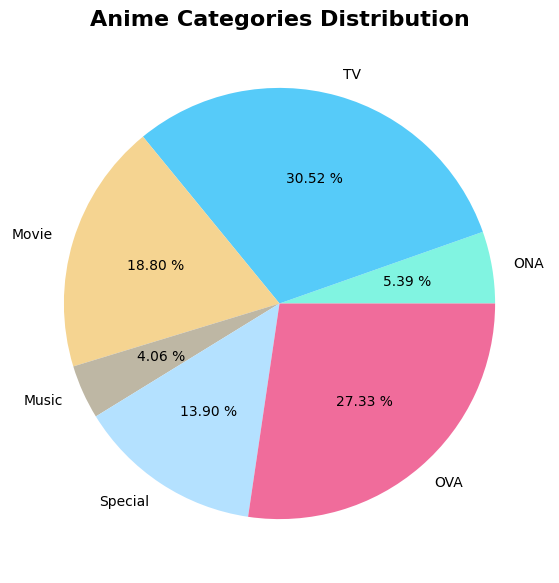

In [21]:
ona = len(anime.loc[anime['type'] == 'ONA'])
tv = len(anime.loc[anime['type'] == 'TV'])
movie = len(anime.loc[anime['type'] == 'Movie'])
music = len(anime.loc[anime['type'] == 'Music'])
special = len(anime.loc[anime['type'] == 'Special'])
ova = len(anime.loc[anime['type'] == 'OVA'])

labels = ['ONA', 'TV', 'Movie', 'Music', 'Special', 'OVA']
colors = ['#81F4E1', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B']

plt.figure(figsize = (10,7))
plt.title('Anime Categories Distribution', fontsize=16, fontweight='bold')
plt.pie([ona, tv, movie, music, special, ova],
  labels = labels,
  colors = colors,
  autopct = '%.2f %%'
  )
  
plt.show()


### 7.2 Anime's Average Ratings Distribution


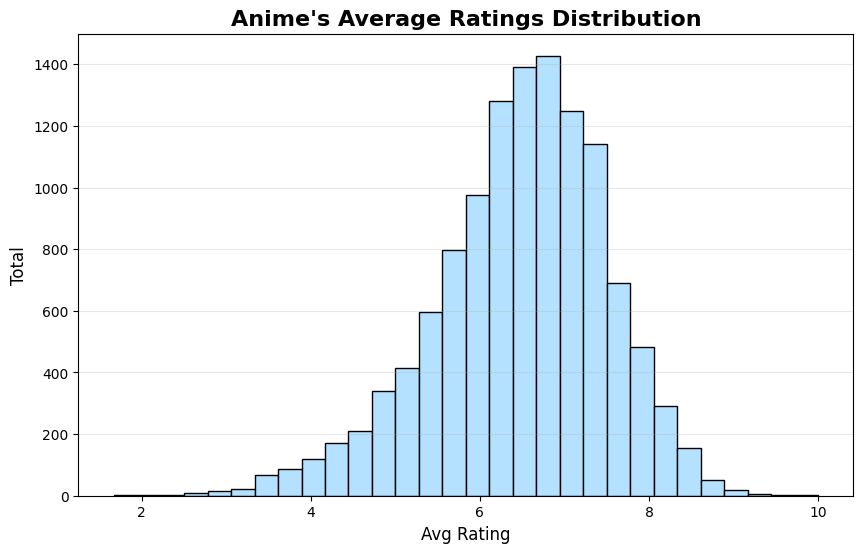

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(anime.rating, color='#B4E1FF', edgecolor='black', bins=30)
plt.ylabel('Total', fontsize=12)
plt.xlabel('Avg Rating', fontsize=12)
plt.title("Anime's Average Ratings Distribution", fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()


### 7.3 User Anime Ratings Distribution


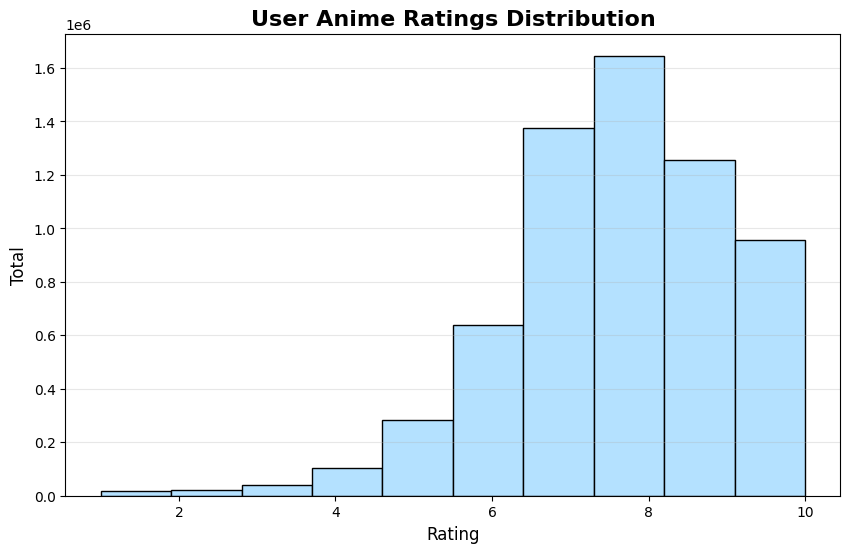

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(anime_rating.rating, color='#B4E1FF', edgecolor='black', bins=10)
plt.ylabel('Total', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.title("User Anime Ratings Distribution", fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()


### 7.4 Top 10 Anime by Community Members


In [24]:
top10_anime_members = anime.sort_values(by='members', ascending=False).head(10)
print("Top 10 Anime by Community Members:")
display(top10_anime_members[['name', 'members', 'rating', 'type']])


Top 10 Anime by Community Members:


,name,members,rating,type
40,Death Note,1013917,8.71,TV
86,Shingeki no Kyojin,896229,8.54,TV
804,Sword Art Online,893100,7.83,TV
1,Fullmetal Alchemist: Brotherhood,793665,9.26,TV
159,Angel Beats!,717796,8.39,TV
19,Code Geass: Hangyaku no Lelouch,715151,8.83,TV
841,Naruto,683297,7.81,TV
3,Steins;Gate,673572,9.17,TV
445,Mirai Nikki (TV),657190,8.07,TV
131,Toradora!,633817,8.45,TV


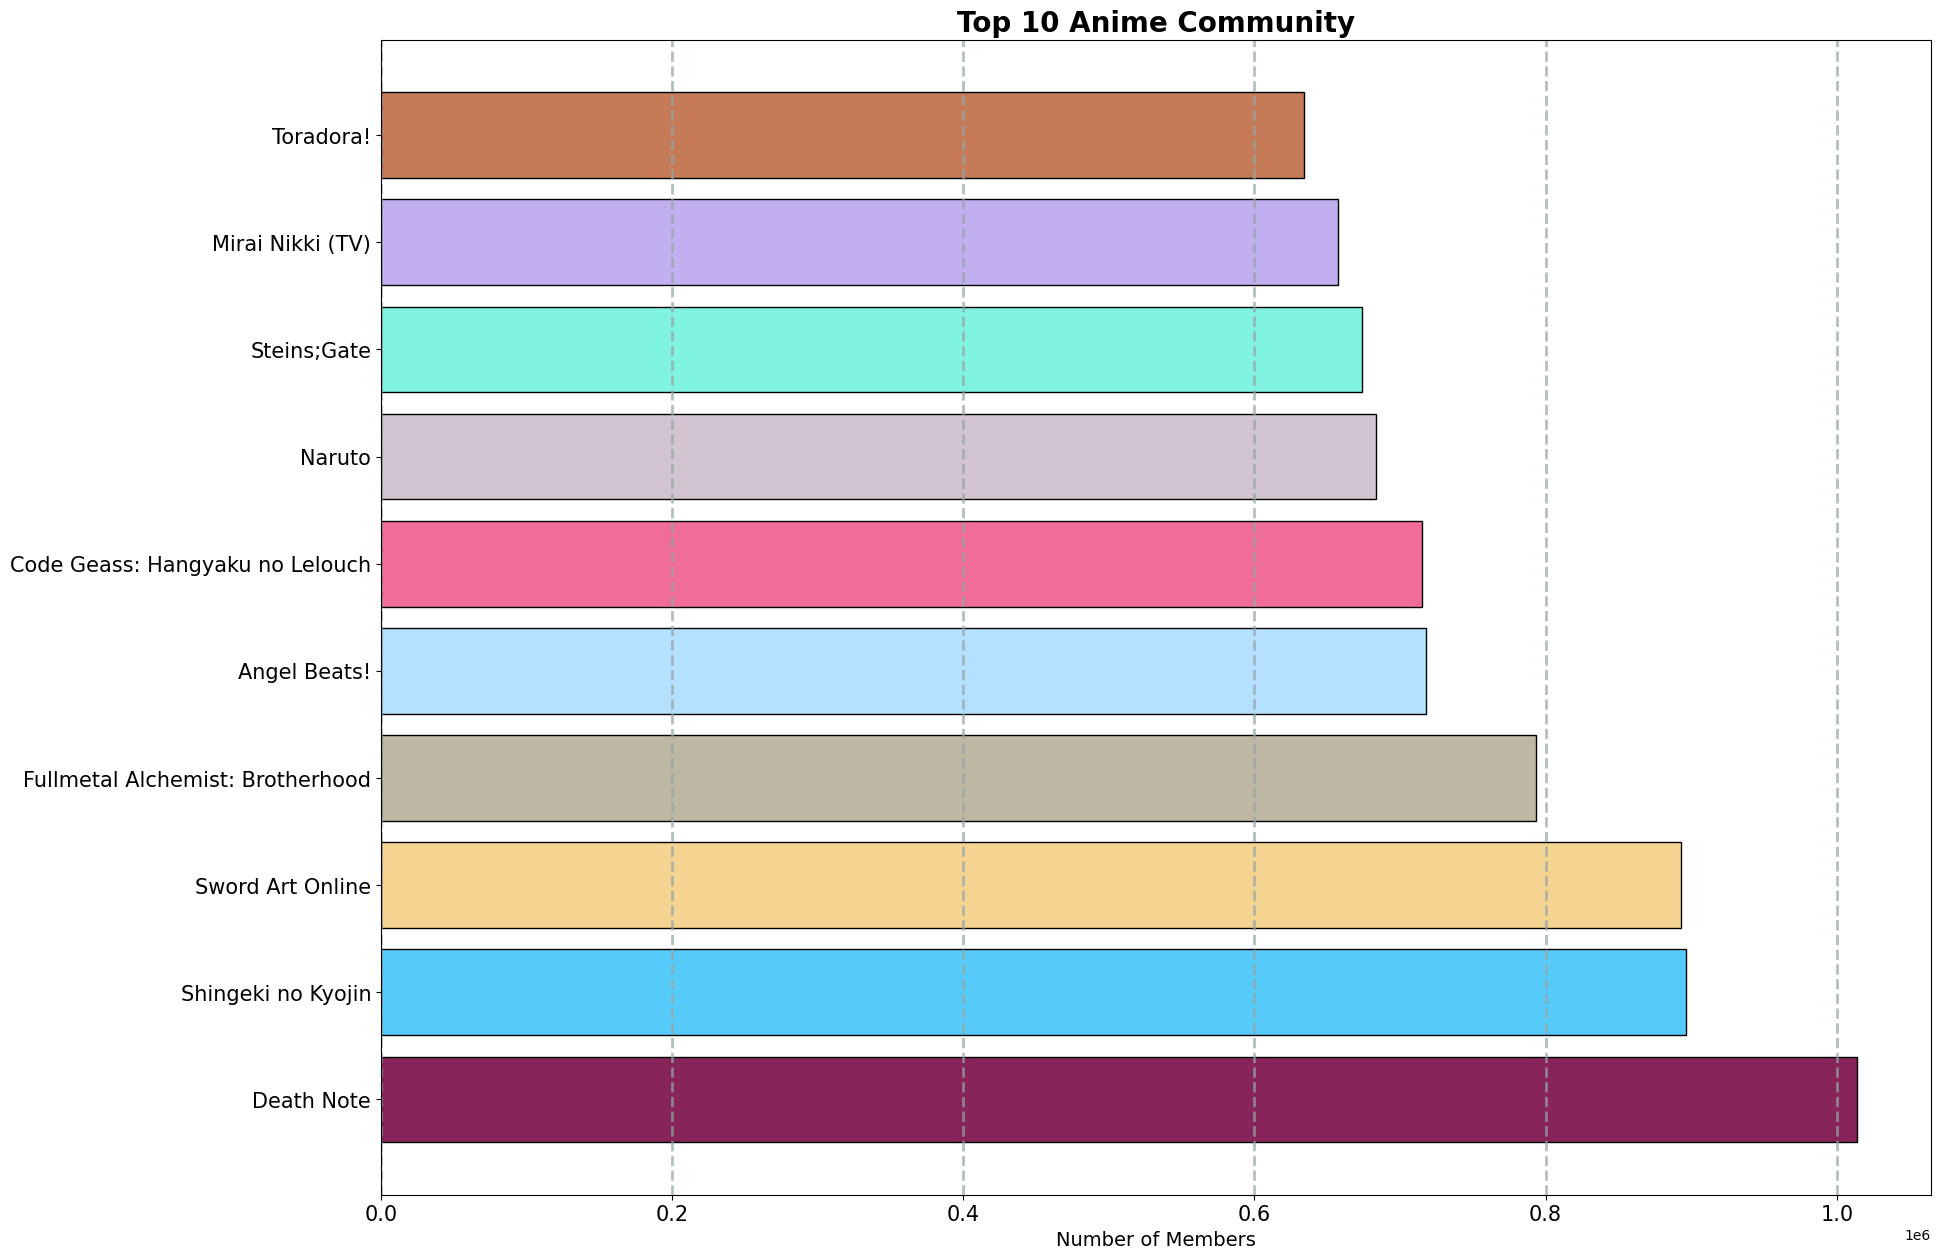

In [25]:
plt.figure(figsize = (20,15))
top10_anime = anime[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['members']].values.flatten()

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Community", fontdict = {'fontsize' : 20, 'fontweight': 'bold'})
plt.xlabel('Number of Members', fontsize=14)
plt.show()


### 7.5 Top 10 Anime by Average Rating


In [26]:
top10_anime_rating = anime.sort_values(by='rating', ascending=False).head(10)
print("Top 10 Anime by Average Rating:")
display(top10_anime_rating[['name', 'rating', 'members', 'type']])


Top 10 Anime by Average Rating:


,name,rating,members,type
10464,Taka no Tsume 8: Yoshida-kun no X-Files,10.00,13,Movie
10400,Spoon-hime no Swing Kitchen,9.60,47,TV
9595,Mogura no Motoro,9.50,62,Movie
0,Kimi no Na wa.,9.37,200630,Movie
9078,Kahei no Umi,9.33,44,Movie
1,Fullmetal Alchemist: Brotherhood,9.26,793665,TV
10786,Yakusoku: Africa Mizu to Midori,9.25,53,OVA
2,Gintama°,9.25,114262,TV
3,Steins;Gate,9.17,673572,TV
4,Gintama,9.16,151266,TV


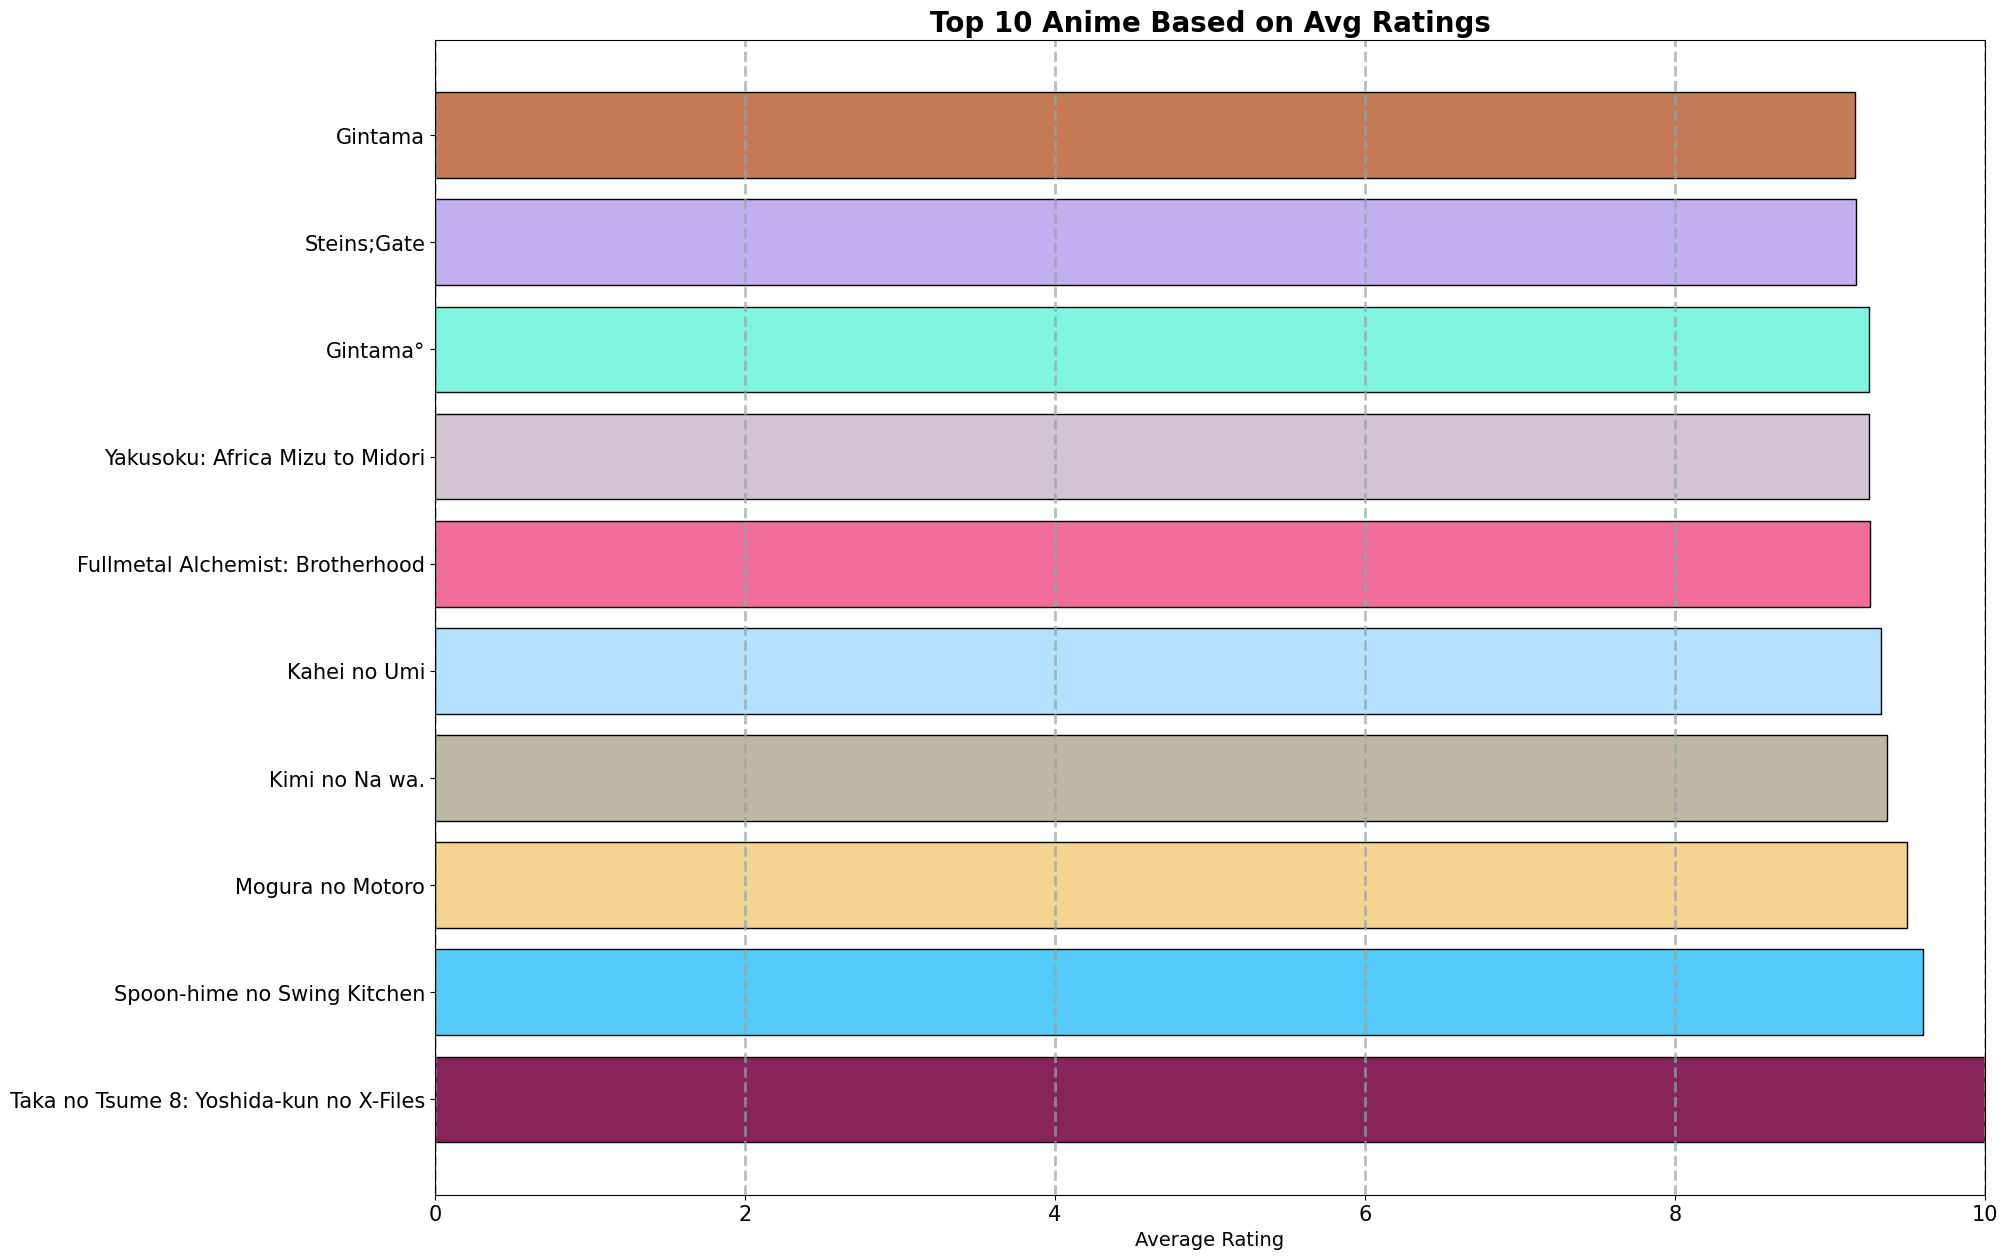

In [27]:
plt.figure(figsize = (20,15))
top10_anime = anime[['name', 'rating']].sort_values(by = 'rating',ascending = False).head(10)

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['rating']].values.flatten()

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Based on Avg Ratings", fontdict = {'fontsize' : 20, 'fontweight': 'bold'})
plt.xlabel('Average Rating', fontsize=14)
plt.xlim(0, 10)
plt.show()


### 7.6 Top 10 Anime by Rating Contribution


In [28]:
anime_rating_contribution = anime_rating.groupby('anime_id').count()
anime2 = anime.drop(['rating'], axis = 'columns')
name_anime_rating_contribution = pd.merge(anime_rating_contribution, anime2, on = 'anime_id', how = 'left')
top10_contribution = name_anime_rating_contribution.sort_values(by='rating', ascending=False).head(10)

print("Top 10 Anime by Rating Contribution:")
display(top10_contribution[['name', 'rating', 'members', 'type']])


Top 10 Anime by Rating Contribution:


,name,rating,members,type
1388,Death Note,34226,1013917.0,TV
6323,Sword Art Online,26310,893100.0,TV
7059,Shingeki no Kyojin,25289,896229.0,TV
1426,Code Geass: Hangyaku no Lelouch,24126,715151.0,TV
4567,Angel Beats!,23565,717796.0,TV
201,Elfen Lied,23528,623511.0,TV
10,Naruto,22071,683297.0,TV
3936,Fullmetal Alchemist: Brotherhood,21494,793665.0,TV
99,Fullmetal Alchemist,21332,600384.0,TV
2642,Code Geass: Hangyaku no Lelouch R2,21124,572888.0,TV


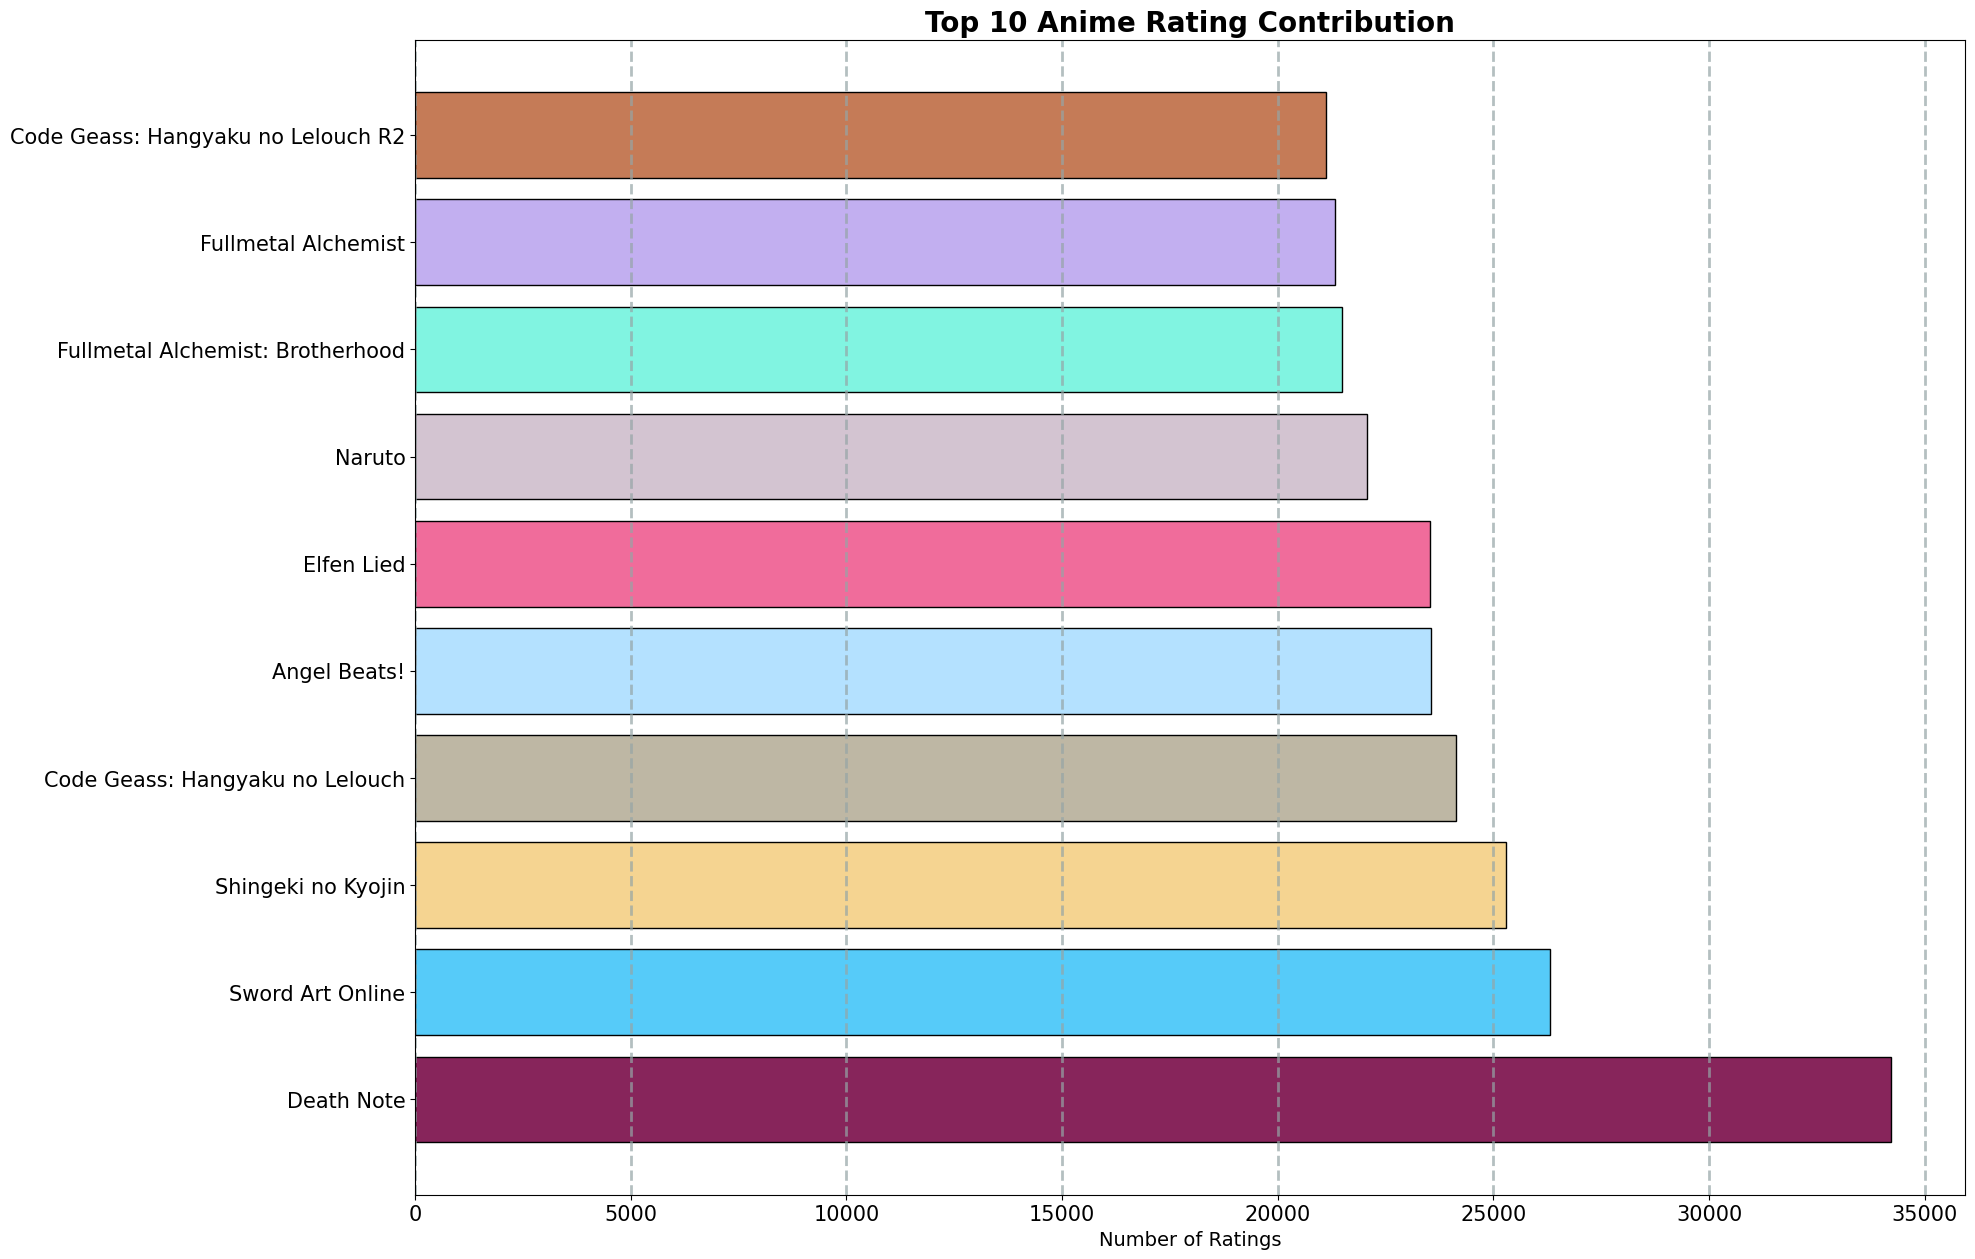

In [29]:
plt.figure(figsize = (20,15))
top10_anime = name_anime_rating_contribution[['name', 'rating']].sort_values(by = 'rating',ascending = False).head(10)

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['rating']].values.flatten()

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Rating Contribution", fontdict = {'fontsize' : 20, 'fontweight': 'bold'})
plt.xlabel('Number of Ratings', fontsize=14)
plt.show()


## 8. Content-Based Recommendation System

### 8.1 TF-IDF Vectorization


In [30]:
# Initialize TF-IDF Vectorizer
tf = TfidfVectorizer()
tf.fit(anime['genre']) 

print("TF-IDF Feature Names (first 20):")
print(tf.get_feature_names_out()[:20])
print(f"\nTotal features: {len(tf.get_feature_names_out())}")


TF-IDF Feature Names (first 20):
['action' 'adventure' 'ai' 'arts' 'cars' 'comedy' 'dementia' 'demons'
 'drama' 'ecchi' 'fantasy' 'fi' 'game' 'harem' 'hentai' 'historical'
 'horror' 'josei' 'kids' 'life']

Total features: 47


In [31]:
# Transform genre to TF-IDF matrix
tfidf_matrix = tf.fit_transform(anime['genre'])
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Matrix type: {type(tfidf_matrix)}")


TF-IDF Matrix Shape: (12017, 47)
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>


In [32]:
# Sample TF-IDF matrix (dense representation for visualization)
tfidf_sample = pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=anime.name
).sample(22, axis=1).sample(10, axis=0)

print("Sample TF-IDF Matrix (10 anime x 22 genres):")
display(tfidf_sample)


Sample TF-IDF Matrix (10 anime x 22 genres):


,life,josei,hentai,dementia,game,yuri,martial,yaoi,seinen,comedy,...,kids,samurai,historical,power,fantasy,shounen,school,military,shoujo,supernatural
name,,,,,,,,,,,,,,,,,,,,,
Peeping Life: Gekijou Original-ban,0.545968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.325202,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Vandread: Gekitou-hen,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.219060,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
To LOVE-Ru Darkness 2nd OVA,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.212177,...,0.000000,0.0,0.0,0.0,0.000000,0.316183,0.358752,0.0,0.0,0.0
Hashire!,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Tanoshii Muumin Ikka,0.426690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.254155,...,0.390110,0.0,0.0,0.0,0.346350,0.000000,0.000000,0.0,0.0,0.0
Sore Ike! Anpanman: Yousei Rinrin no Himitsu,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.437978,...,0.672265,0.0,0.0,0.0,0.596854,0.000000,0.000000,0.0,0.0,0.0
Bouken Korobokkuru,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Shoujo Koakuma Kei,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
Detective Conan Magic File 3: Shinichi and Ran - Memories of Mahjong Tiles and Tanabata,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.571302,0.000000,0.0,0.0,0.0


### 8.2 Cosine Similarity Calculation


In [33]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
print(f"Cosine Similarity Matrix Shape: {cosine_sim.shape}")
print(f"Similarity range: [{cosine_sim.min():.4f}, {cosine_sim.max():.4f}]")


Cosine Similarity Matrix Shape: (12017, 12017)
Similarity range: [0.0000, 1.0000]


In [34]:
# Convert to DataFrame for easier access
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime['name'], columns=anime['name'])
print('Cosine Similarity DataFrame Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix sample
print("\nSample Similarity Matrix (10 anime x 5 anime):")
display(cosine_sim_df.sample(5, axis=1).sample(10, axis=0))


Cosine Similarity DataFrame Shape: (12017, 12017)

Sample Similarity Matrix (10 anime x 5 anime):


name,Coluboccoro,Shiritori Mambo,Kowabon,Precure All Stars Movie DX2: Kibou no Hikari☆Rainbow Jewel wo Mamore!,Mitsuami no Kamisama
name,,,,,
Seihou Tenshi Angel Links,0.387795,0.000000,0.0,0.111179,0.124113
Shijin no Shougai,0.239566,0.000000,0.0,0.173667,0.164573
Sensou no Tsukurikata,0.000000,0.466107,0.0,0.000000,0.251844
Blood-C: None-None Gekijou,0.000000,0.000000,0.0,0.000000,0.000000
Dororon Enma-kun Meeramera,0.154296,0.000000,0.0,0.429170,0.000000
Navia Dratp,0.333113,0.622324,0.0,0.241481,0.000000
Magic Knight Rayearth,0.170961,0.000000,0.0,0.636835,0.117444
Futsuu no Joshikousei ga [Locodol] Yattemita.,0.000000,0.000000,0.0,0.000000,0.489888
Yamato yo Towa ni,0.373620,0.000000,0.0,0.107115,0.119576


### 8.3 Recommendation Function


In [35]:
def anime_recommendations(name, similarity_data=cosine_sim_df, items=anime[['name', 'genre']], k=10):
    """
    Fungsi untuk memberikan rekomendasi anime berdasarkan similarity
    
    Parameters:
    -----------
    name : str
        Nama anime yang ingin dicari rekomendasinya
    similarity_data : DataFrame
        DataFrame berisi cosine similarity matrix
    items : DataFrame
        DataFrame berisi informasi anime (name, genre)
    k : int
        Jumlah rekomendasi yang ingin ditampilkan
    
    Returns:
    --------
    DataFrame
        DataFrame berisi k rekomendasi anime
    """
    # Cek apakah anime ada dalam dataset
    if name not in similarity_data.index:
        print(f"Anime '{name}' tidak ditemukan dalam dataset.")
        return pd.DataFrame()
    
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,name].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop name agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(name, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

print("Recommendation function created!")


Recommendation function created!


### 8.4 Testing Recommendation System


In [36]:
# Test 1: Dragon Ball Z
anime_name = 'Dragon Ball Z'
print(f"=== Rekomendasi untuk: {anime_name} ===\n")

# Cek apakah anime ada
anime_info = anime[anime.name.eq(anime_name)]
if len(anime_info) > 0:
    print("Anime Info:")
    display(anime_info[['name', 'genre', 'type', 'rating', 'members']])
    print("\nRekomendasi:")
    recommendations = anime_recommendations(anime_name)
    display(recommendations)
else:
    print(f"Anime '{anime_name}' tidak ditemukan.")


=== Rekomendasi untuk: Dragon Ball Z ===

Anime Info:


,name,genre,type,rating,members
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,8.32,375662



Rekomendasi:


,name,genre
0,Dragon Ball Z: Atsumare! Gokuu World,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
1,Dragon Ball Super,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
2,Dragon Ball GT: Goku Gaiden! Yuuki no Akashi w...,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
3,Dragon Ball Z Movie 11: Super Senshi Gekiha!! ...,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
4,Dragon Ball Z: Summer Vacation Special,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
5,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
6,Dragon Ball Z Movie 15: Fukkatsu no F,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
7,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar..."
8,Dragon Ball Z Movie 14: Kami to Kami,"Action, Adventure, Fantasy, Martial Arts, Shou..."
9,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou..."


In [37]:
# Test 2: Shingeki no Kyojin
anime_name = 'Shingeki no Kyojin'
print(f"=== Rekomendasi untuk: {anime_name} ===\n")

anime_info = anime[anime.name.eq(anime_name)]
if len(anime_info) > 0:
    print("Anime Info:")
    display(anime_info[['name', 'genre', 'type', 'rating', 'members']])
    print("\nRekomendasi:")
    recommendations = anime_recommendations(anime_name)
    display(recommendations)
else:
    print(f"Anime '{anime_name}' tidak ditemukan.")


=== Rekomendasi untuk: Shingeki no Kyojin ===

Anime Info:


,name,genre,type,rating,members
86,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,8.54,896229



Rekomendasi:


,name,genre
0,Shingeki no Kyojin Movie 1: Guren no Yumiya,"Action, Drama, Fantasy, Shounen, Super Power"
1,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,"Action, Drama, Fantasy, Shounen, Super Power"
2,Shingeki no Kyojin: Ano Hi Kara,"Action, Drama, Fantasy, Shounen, Super Power"
3,Shingeki no Kyojin OVA,"Action, Drama, Fantasy, Shounen, Super Power"
4,Saint Seiya: Meiou Hades Elysion-hen,"Action, Fantasy, Shounen, Super Power"
5,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
6,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
7,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
8,One Piece: Romance Dawn,"Action, Comedy, Fantasy, Shounen, Super Power"
9,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."


In [38]:
# Test 3: Pokemon
anime_name = 'Pokemon'
print(f"=== Rekomendasi untuk: {anime_name} ===\n")

anime_info = anime[anime.name.eq(anime_name)]
if len(anime_info) > 0:
    print("Anime Info:")
    display(anime_info[['name', 'genre', 'type', 'rating', 'members']])
    print("\nRekomendasi:")
    recommendations = anime_recommendations(anime_name)
    display(recommendations)
else:
    print(f"Anime '{anime_name}' tidak ditemukan.")


=== Rekomendasi untuk: Pokemon ===

Anime Info:


,name,genre,type,rating,members
1834,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids",TV,7.43,229157



Rekomendasi:


,name,genre
0,Pokemon Diamond and Pearl,"Action, Adventure, Comedy, Fantasy, Kids"
1,Digimon Universe: Appli Monsters,"Action, Adventure, Comedy, Fantasy, Kids"
2,Pokemon Best Wishes! Season 2: Decolora Advent...,"Action, Adventure, Comedy, Fantasy, Kids"
3,Pokemon Best Wishes! Season 2: Decolora Advent...,"Action, Adventure, Comedy, Fantasy, Kids"
4,Pokemon Crystal: Raikou Ikazuchi no Densetsu,"Action, Adventure, Comedy, Fantasy, Kids"
5,Pokemon: The Origin,"Action, Adventure, Comedy, Fantasy, Kids"
6,Pokemon XYandZ Specials,"Action, Adventure, Comedy, Fantasy, Kids"
7,Pokemon XY: Mega Evolution,"Action, Adventure, Comedy, Fantasy, Kids"
8,Pokemon Best Wishes! Season 2: Episode N,"Action, Adventure, Comedy, Fantasy, Kids"
9,Pokemon XY: New Year Special,"Action, Adventure, Comedy, Fantasy, Kids"


## 9. Summary

Notebook ini telah melakukan preprocessing data yang lengkap meliputi:

1. ✅ **Data Quality Validation** - Validasi kualitas data
2. ✅ **Missing Values Handling** - Penanganan missing values
3. ✅ **Duplicate Removal** - Penghapusan duplikat
4. ✅ **Data Type Conversion** - Konversi episodes ke numeric
5. ✅ **Text Cleaning** - Pembersihan text dengan perbaikan warning
6. ✅ **Outlier Detection** - Deteksi outlier (tidak dihapus karena mungkin valid)
7. ✅ **Data Filtering** - Filter rating -1
8. ✅ **Feature Engineering** - Genre count, normalized members, rating category
9. ✅ **Collaborative Filtering Prep** - Analisis sparsity
10. ✅ **Visualization** - Berbagai visualisasi data
11. ✅ **Content-Based Recommendation** - Sistem rekomendasi berbasis konten

Sistem rekomendasi menggunakan **TF-IDF Vectorization** dan **Cosine Similarity** untuk menemukan anime yang mirip berdasarkan genre.
